<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cifar10_linear_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install self_supervised
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import kornia.augmentation as korniatfm
import torchvision.transforms as tvtfm
import torch
device='cuda' if torch.cuda.is_available() else 'cpu'
cuda=(device=='cuda')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Ok, let's try training a linear classifier on CIFAR10, using the FastAI `learn` API via copy-pasting from BarlowTwins self_supervised as needed. We want to include RandomResizedCrop, on the GPU etc.

In [140]:
path

Path('/root/.fastai/data/cifar10')

In [148]:
n_in=3
size=128
bs=512
path = untar_data(URLs.CIFAR)
path

fnames = get_image_files(path / "train")

def label_func(fname):
    return fname.name.split('_')[1].strip('png').strip('.')
    
labels = [label_func(fname) for fname in fnames]

dls = ImageDataLoaders.from_lists(path, fnames, labels,bs=bs, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.5,num_workers=6,device=device,seed=42)
set(labels) #Check that the labels make sense

{'airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck'}

In [117]:
type(dls.train.one_batch()[0])

fastai.torch_core.TensorImage

In [101]:
#Batch level augmentations for linear classifier. At present time, just RandomResizedCrop and Normalization.
def get_batch_augs(size,
                    resize_scale=(0.08, 1.0),resize_ratio=(3/4, 4/3),
                    stats=None,cuda=default_device().type == 'cuda',xtra_tfms=[]):
    
    "Input batch augmentations implemented in tv+kornia+fastai"
    tfms = []
    tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]
    tfms += xtra_tfms
    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

In [155]:
#Linear model 
class LinearModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,indim,outdim=10):
        self.L = nn.Linear(indim,1024)
        self.L0 = nn.Linear(1024,1024)
        self.L2 = nn.Linear(1024,outdim)
        self.relu = nn.ReLU()
        
    def forward(self,x): 
            x=self.relu(self.L(x.view(x.shape[0],-1)))
            x=self.relu(self.L0(x))
            x=self.L2(x)
            return x

# def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
#     "Create Barlow Twins model"
#     n_in  = in_channels(encoder)
#     with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
#     projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
#     apply_init(projector)
#     return BarlowTwinsModel(encoder, projector)

In [156]:
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self,aug_pipelines,n_in, lmb=5e-3, show_batch=False, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1= aug_pipelines[0]
        self.aug2=Pipeline( split_idx = 0) #empty pipeline
        if print_augs: print(self.aug1), print(self.aug2)
        self.n_in=n_in
        self._show_batch=show_batch
        self.criterion = nn.CrossEntropyLoss()

    def before_fit(self): 
        self.learn.loss_func = self.lf
            
    def before_batch(self):

        if self.n_in == 1:
            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))                            
        elif self.n_in == 3:
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))

        self.learn.xb = (xi,)

        if self._show_batch:
            self.learn.aug_x = torch.cat([xi, xj])

    def lf(self, pred, *yb):        
        loss=self.criterion(pred,self.y)
        return loss
    @torch.no_grad()
    def show(self, n=1):
        if self._show_batch==False:
            print('Need to set show_batch=True')
            return
        bs = self.learn.aug_x.size(0)//2
        x1,x2  = self.learn.aug_x[:bs], self.learn.aug_x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)


#debugging block
n_in=3
model = LinearModel(indim=size*size*3)

#dummy_stats = ([0,0,0],[0.0001,0.0001,0.0001])
aug_pipelines = [get_batch_augs(size=size,stats=cifar_stats,resize_scale=(0.3, 1.0))]
bt = BarlowTwins(aug_pipelines,show_batch=False,n_in=n_in,print_augs=True)
learn = Learner(dls,model, cbs=[bt])
learn.fit(100)
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=25)

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: 


epoch,train_loss,valid_loss,time
0,3.743210,1.991305,00:25
1,2.417078,1.876957,00:26
2,2.032204,1.845719,00:26
3,1.883569,1.776283,00:26
4,1.806526,1.810887,00:26
5,1.750013,1.742447,00:25
6,1.736319,1.756815,00:26
7,1.712878,1.736967,00:25
8,1.673663,1.728115,00:25
9,1.659467,1.685343,00:26


KeyboardInterrupt: ignored

In [ ]:
learn.fit(1)

In [46]:
tem.prac()

hi called prac


In [50]:
class A:
    pass

a=A()
A(),A()

(<__main__.A at 0x7fdfe66c4cd0>, <__main__.A at 0x7fdfe66c4a10>)

In [51]:
def f():
    return 

def g():
    return

f(),g()

(None, None)

In [16]:
b[0].shape

torch.Size([250, 3, 128, 128])

In [32]:
learn.barlow_twins

BarlowTwins

Pipeline: RandomResizedCrop
Pipeline: 


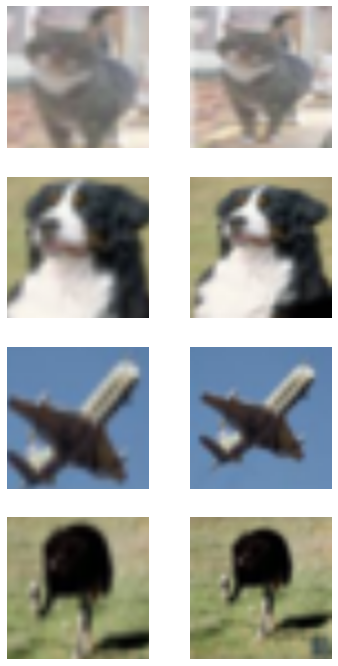

In [113]:
n_in=3
model = LinearModel(indim=size*size*3)


aug_pipelines = [get_batch_augs(size=size)]
tem = BarlowTwins(aug_pipelines,n_in=n_in,print_augs=True)
learn = Learner(dls,model, cbs=[tem])

b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=4)

In [166]:
dummy_stats = ([0,0,0],[0.0,0.000001,0.000001])

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0]],

         [[0]],

         [[0]]]], device='cuda:0'), 'std': tensor([[[[0.0000e+00]],

         [[1.0000e-06]],

         [[1.0000e-06]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: 
TensorImage(nan, device='cuda:0')
before decode
TensorImage(5874273., device='cuda:0')
after decode


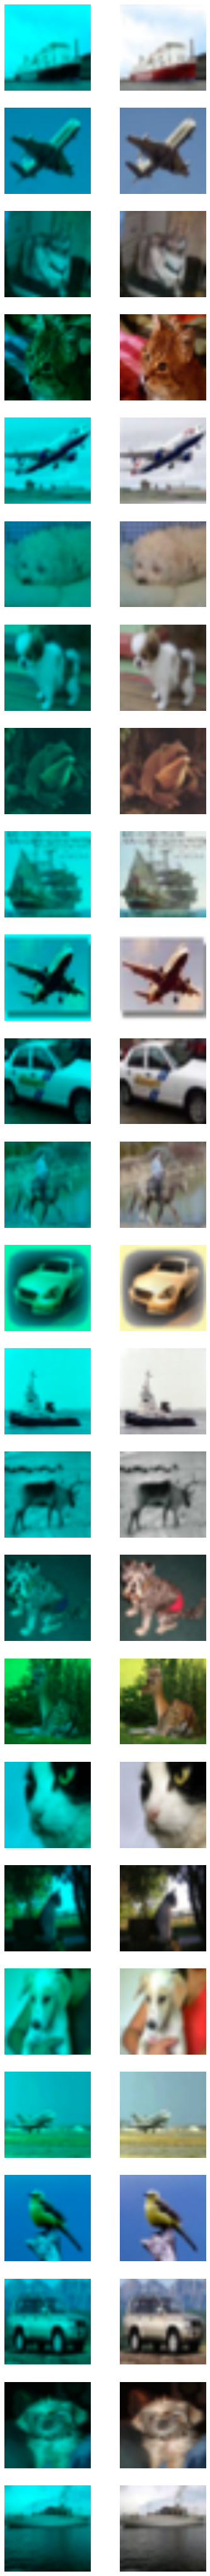

In [174]:
n_in=3
model = LinearModel(indim=size*size*3)
aug_pipelines = [get_batch_augs(size=size,stats=dummy_stats,resize_scale=(1.0, 1.0))]
tem = BarlowTwins(aug_pipelines,n_in=n_in,print_augs=True)
learn = Learner(dls,model, cbs=[tem])
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=25)

In [145]:
aug_pipelines[0].decode

Object `decode` not found.
